# Data Analysis Immo_Rent

This data analysis intends to be completely independant of magic numbers and variable names. For this reason, the columns of the data set must be in the right order: immoId, objType, cityName, zipCode, regionId, canton, street, rooms, floor, surface, yearBuilt, yearRenovated, lon, lat, distanceToStation, netPrice, extraPrice, price

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sys

df = pd.read_csv('..\\data_file\\object_file - modified_v2.csv')

#removes the semicolon of the last attributes if exists
def remove_semicolon(row):
    return row[df.columns[df.shape[1]-1]][:-1]
if df.columns[df.shape[1]-1][-1] == ';': 
    df.rename(columns = {df.columns[df.shape[1]-1] : df.columns[df.shape[1]-1][:len(df.columns[df.shape[1]-1])-1]}, inplace = True)
    df[df.columns[df.shape[1]-1]] = df.apply(lambda row: remove_semicolon(row), axis=1)


df_size = df.shape[0]
percentage = '{0:.0%}'
count = 'count'
float_regex = '\d+(\.)?(\d)*'
na = '<NA>'

## 1 Missing Values

### Missing Values Dependency

First we have to get an imagination of where and why I have missing values. In addition, I want to know if the density of missing values has any connection to other missing values.

In order to get an overview of these missing values, I created a heatmap of each attribute in the data-set.

In [2]:
def create_missing_values_table():
    """creates a full table of each row and column of the dataframe and checks, how many missing values are in the comparison"""
    missing_values_table = pd.DataFrame(0, index = df.columns, columns=df.columns)
    for column in df.columns:
        for row in df.columns:
            sub_frame = df[[column, row]]
            try: #compares if both: columns with the values of 'column' and 'row' have missing values, even compared with itself
                num_missing = sub_frame[(sub_frame[column] == na) & (sub_frame[row] == na)].iloc[:,0].value_counts()[na]
            except KeyError: #if there is a KeyError, that means that no missing values are found
                num_missing = 0
            missing_values_table[column][row] = num_missing
    return missing_values_table


missing_values_table = create_missing_values_table()

C:\Users\Lukas\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


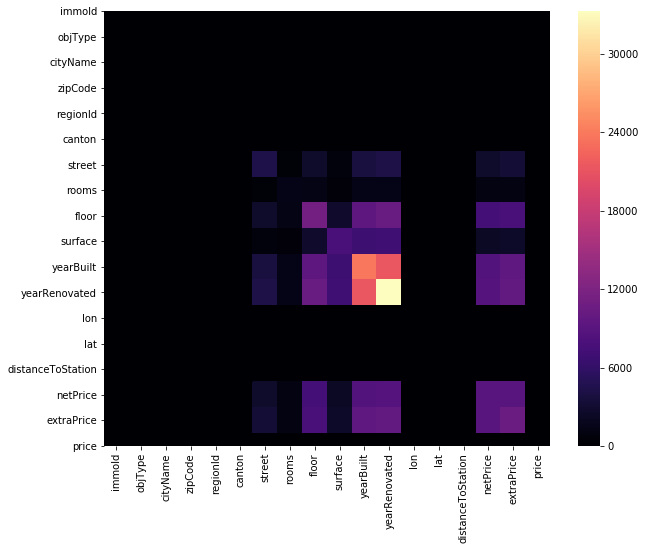

In [3]:
plt.figure(figsize=(10, 8))
sns.heatmap(missing_values_table, cmap="magma")

### Absolute and Relative Missing Values

In [53]:
pd.options.mode.chained_assignment = None #ignores false positive copy warning
rel = 'relative'
missing_count = pd.DataFrame(0, index = df.columns, columns = [na, rel])
for column in df.columns:
    sub_frame = df[column]
    try:
        count_na = sub_frame.value_counts()[na]
        missing_count[na][column] = count_na
        missing_count[rel][column] = percentage.format(count_na / df_size)
    except KeyError:
        missing_count[na][column] = 0
        missing_count[rel][column] = percentage.format(0)
        
print(missing_count)

                    <NA> relative
immoId                 0       0%
objType                0       0%
cityName               0       0%
zipCode                0       0%
regionId               0       0%
canton                17       0%
street              4326      11%
rooms               1382       4%
floor              11139      29%
surface             7892      21%
yearBuilt          23855      63%
yearRenovated      33277      87%
lon                    0       0%
lat                    0       0%
distanceToStation      0       0%
netPrice            9020      24%
extraPrice         10428      27%
price                  0       0%


### Missing Values per Object Distribution / Data Transformation

In [5]:
def count_na_in_row(row):
    row_count = 0
    for value in row:
        if value == na:
            row_count += 1
    return row_count

miss = 'missing_class'
miss_range = None
def create_missing_values_set(): #about 10 sec
    df_missing = df.copy() #copy to not alter the original data-set
    df_missing[miss] = df_missing.apply(lambda row: count_na_in_row(row), axis=1) #creates missing_class (num_of_missing_values)
    df_missing_grouped = df_missing.groupby(miss)
    global miss_range
    miss_range = range(1, df_missing[miss].max()+1)
    missing_set = pd.DataFrame(index = miss_range)
    for attribute in df.columns:
        values = []
        for i in miss_range:
            try: #tries to get the counted grouped value <NA> of the specific attribute
                values.append(df_missing_grouped[attribute].value_counts()[i, na])
            except KeyError:
                values.append(0)
        missing_set[attribute] = values
    return missing_set

#missing_set = create_missing_values_set().set_index(miss)
missing_set = create_missing_values_set()
print(missing_set)

   immoId  objType  cityName  zipCode  regionId  canton  street  rooms  floor  \
1       0        0         0        0         0       0      13      7    173   
2       0        0         0        0         0       1     251     28   1182   
3       0        0         0        0         0       4     659     91   1258   
4       0        0         0        0         0       0     591     76   1108   
5       0        0         0        0         0       0     669     55   3682   
6       0        0         0        0         0       6    1292    475   2645   
7       0        0         0        0         0       4     638    437    878   
8       0        0         0        0         0       1     212    212    212   
9       0        0         0        0         0       1       1      1      1   

   surface  yearBuilt  yearRenovated  lon  lat  distanceToStation  netPrice  \
1       94       1239           9115    0    0                  0         0   
2     1115       7591          

### Missing Values Distribution of each Data Object

This plot describes of how the missing values are distributed in data objects, where 1, 2, 3.. values are missing. The y-axis describes how many of these missing attributes are found. If one is interested in how many data objects with missing values 1, 2, 3.. exists, take a look at the next plot, because it was not appropriate to show this information here. 

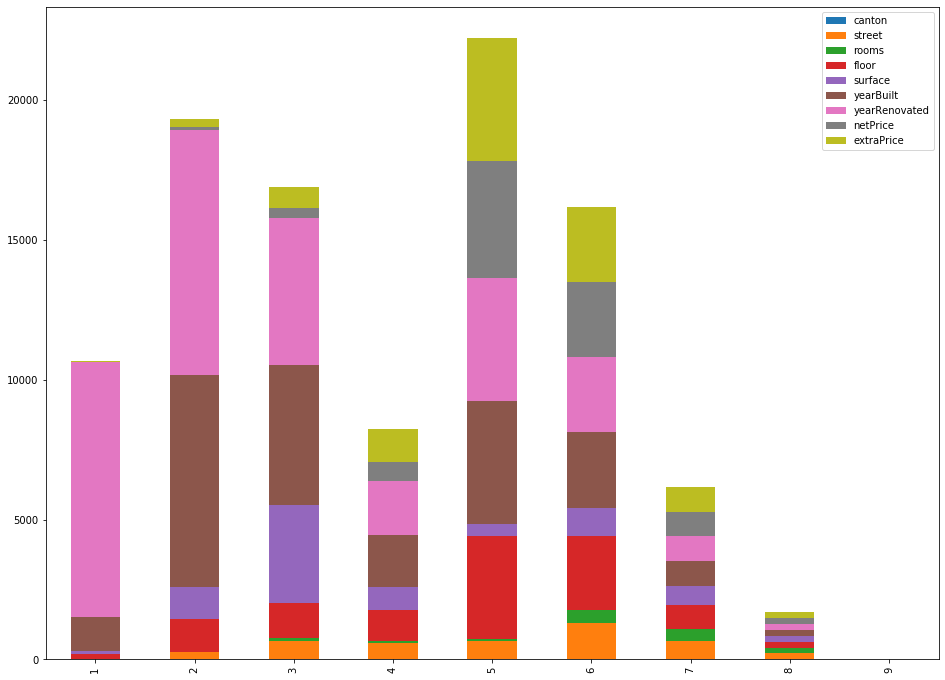

In [49]:
missing_set = missing_set.loc[:, (missing_set != 0).any(axis=0)] #drops all full zero columns
missing_set.plot(kind='bar', stacked=True, figsize=(16, 12))

Here one can see the distribution of the number of missing value objects.

objects with no missing values:  1915
   missing_class  count
1              1  10664
2              2   9654
3              3   5628
4              4   2059
5              5   4442
6              6   2696
7              7    879
8              8    212
9              9      1


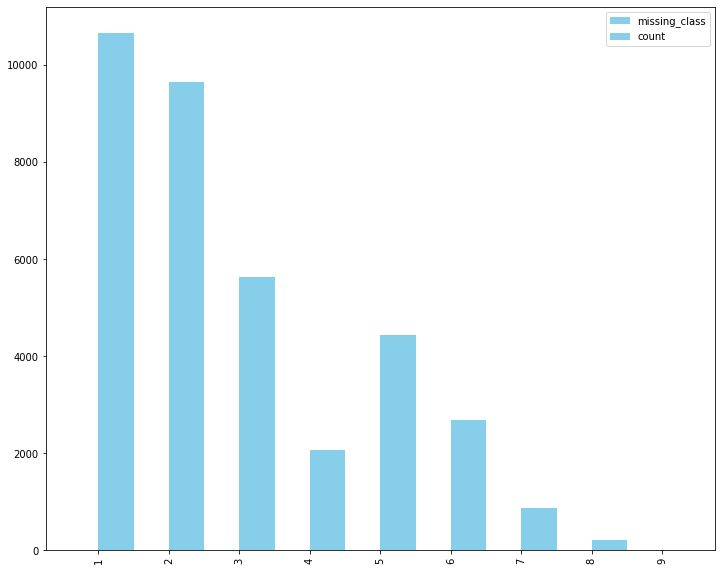

In [39]:
missing_set_objects = pd.DataFrame(index = miss_range)
missing_set_objects[miss] = miss_range
missing_set_objects[count] = missing_set.sum(axis = 1)
for missing_class in miss_range: #adapt count values to count objects
    missing_set_objects[count][missing_class] = missing_set_objects[count][missing_class] / missing_class

missing_set_objects.plot(kind='bar', figsize=(12, 10), width = 1, color = 'skyblue')
print('objects with no missing values: ', df_size - missing_set_objects[count].sum(axis = 0))
print(missing_set_objects)

## 2 Dimensonal Analysis

### Object Type

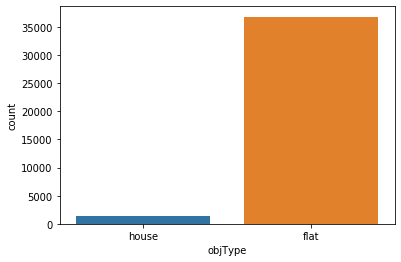

In [8]:
sns.countplot(x=df.columns[1], data=df)

### City and Zip-Code

   zipCode  count
0     2300    529
1     9000    399
2     1700    382
3     1950    359
4     6900    345
5     2000    307


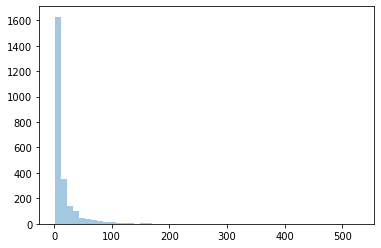

In [9]:
plz_count = df.zipCode.value_counts().rename_axis(df.columns[3]).reset_index(name = count)
sns.distplot(plz_count[[count]], bins = 50, norm_hist = False, kde = False)
print(plz_count[0:6])

### Canton

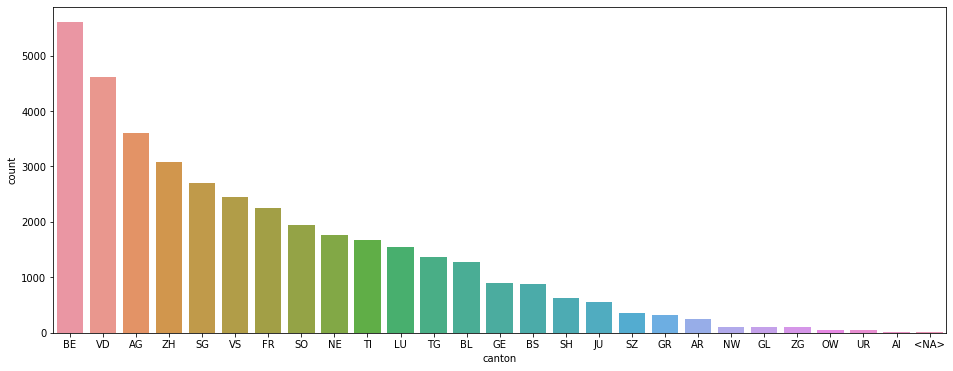

In [10]:
plt.figure(figsize=(16, 6))
sns.countplot(x = df.columns[5], data = df, order = df[df.columns[5]].value_counts().index)

### Street

In [11]:
street_na = df.street.value_counts()
print('NAs: ', street_na[na], ' (', percentage.format(street_na[na] / df_size), ')')

NAs:  4326  ( 11% )


### Rooms

    rooms  count
0     3.5  10369
1     4.5   8762
2     2.5   4393
3     3.0   3619
4     4.0   1858
5     5.5   1824
6     2.0   1818
7     1.0   1530
8    <NA>   1382
9     1.5    926
10    5.0    670
11    6.5    346
12    6.0    285
13    7.0    136
14    7.5     93
15    8.0     38
16    8.5     27
17    9.0     25
18   10.0     24
19    9.5      6
20   10.5      5
21   11.0      4
22   14.0      3
23   12.0      3
24   11.5      2
25  235.0      1
26    3.4      1 

NAs:  4%


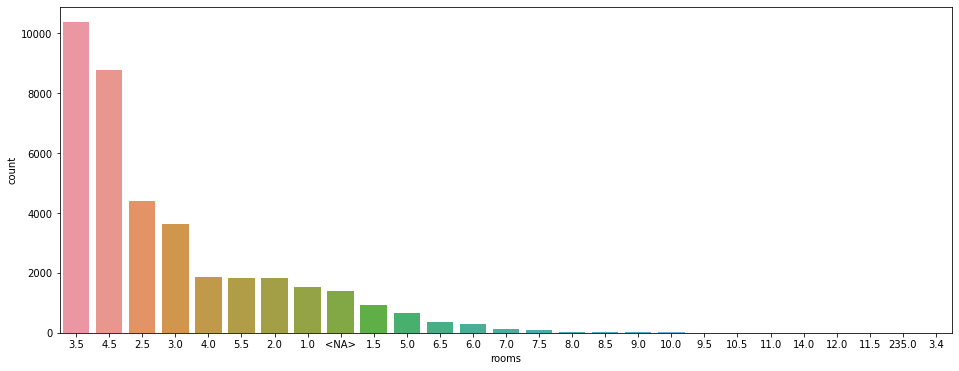

In [12]:
plt.figure(figsize=(16, 6))
df_rooms = df.rooms.value_counts().rename_axis(df.columns[7]).reset_index(name = count)
#df_rooms = df_rooms[df_rooms.rooms != na]
na_rooms = df_rooms[df_rooms[df.columns[7]] == na][count].values[0]
print(df_rooms, "\n\nNAs: ", percentage.format(na_rooms / df_size))
sns.countplot(x = df.columns[7], data = df, order = df[df.columns[7]].value_counts().index)

### Floor

### Surface

### Year Built and Renovated

### Longitude and Latitude

### Distance to Trainstation

### Price